# Predict Wada Scores and compare with LI toolbox

### import modules

In [1]:
%matplotlib inline

import os
import pickle

import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

### get data

In [2]:
wilkeDf = pd.read_csv('../data/processed/li_tool/allWilkeData.csv',index_col=[0,1],header=0)

In [3]:
wilkeDf.shape

(783, 7)

In [ ]:
wilkeDf.head()

## predict clinical judgements using Wilke LIs

### split data into training and testing

In [5]:
my_nest = pickle.load( open('../models/my_nest.p','rb'))
my_test = pickle.load( open('../models/my_test.p','rb'))

In [6]:
df_nest = wilkeDf.loc[my_nest].sort_index()
df_test = wilkeDf.loc[my_test].sort_index()

In [7]:
df_nest.shape,df_test.shape

((521, 7), (262, 7))

### get features and labels

In [8]:
clfDict = pickle.load(open('../models/li_tool_clf.p','r'))

In [9]:
myLabeler = pickle.load( open('../models/myLabeler.p','rb') )

### decide if inconclusive data should be included

In [10]:
def dropInc(X,y,myLabeler):

    # here, we use the labels (y) to find and exclude inconclusive cases
    noInc = np.where(y!=myLabeler.transform(['inconclusive'])[-1])
    
    # both X and y need to be changed
    X = X[noInc[0]]
    y = y[noInc[0]]
    
    return X,y

In [11]:
X = np.array(df_test[df_test.columns[-1]])
y = np.array([myLabeler.transform([df_test.index.levels[0][x]]) for x in df_test.index.labels[0]])

In [12]:
print X.shape,y.shape

(262,) (262, 1)


In [13]:
Xclean,yclean = dropInc(X,y,myLabeler)
print Xclean.shape,yclean.shape

(217,) (217, 1)


### predict the test data

In [14]:
def makeYPreds(X_validate,clf,scaler,myLabeler):
    
    y_pred = []

    for x in X_validate:
        
        # when there is no LI, we consider the case to be inconclusive
        if np.isnan(x).any():
            pred = myLabeler.transform(['inconclusive'])[-1]
            
        # otherwise we apply the actual classifier
        else:
            scaledX = scaler.transform( x.reshape(1,-1) )
            
            thisPred = clf.predict_proba(scaledX)[-1]
            pred = np.where(thisPred==thisPred.max())[-1][-1]
            # if there are only three classes, we tweak the labels
            if thisPred.shape[-1]==3 and pred>0:
                pred+=1
            
        y_pred.append(pred)
    
    return np.array(y_pred)

Example:

In [15]:
c = 'bootstrap'
thisClf = clfDict[c][False]
clf = thisClf['clf']
scaler = thisClf['scaler']
X_validate = df_test[c].values
y_validate = myLabeler.transform([df_test[c].index.levels[0][x] for x in df_test[c].index.labels[0]])
y_pred = makeYPreds(X_validate,clf,scaler,myLabeler)

In [16]:
y_pred

array([2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3,
       1, 2, 1, 2, 1, 3, 2, 2, 1, 3, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 3, 1, 1, 3, 3, 3,
       3, 3, 3, 3, 1, 3, 3, 3, 1])

### evaluate the results and make confusion matrix

In [17]:
def makePred(df_test,c,clfDict,myLabeler,myDrop=True):
    
    thisClf = clfDict[c][myDrop]
    clf = thisClf['clf']
    scaler = thisClf['scaler']
    X_validate = df_test[c].values

    y_pred = makeYPreds(X_validate,clf,scaler,myLabeler)
    y_lab = myLabeler.inverse_transform(y_pred)
    df = pd.DataFrame(y_lab)
    df.index = df_test.index
    df.columns = [c]
    
    return df

In [18]:
predsDf = pd.DataFrame()
for c in clfDict.keys():
    thisDf = makePred(df_test,c,clfDict,myLabeler,myDrop=True)
    predsDf = pd.concat([predsDf,thisDf],axis=1)

In [ ]:
predsDf.tail()

In [20]:
def makeCm(df,c,myLabeler):

    # predictions of left-out data
    y_pred = df[c]
    y_true = [df.index.levels[0][x] for x in df.index.labels[0]]

    # confusion matrix -- input y and y_pred -- result: true in rows, pred in columns
    cm = metrics.confusion_matrix(y_true,y_pred)

    # put into df
    cmDf = pd.DataFrame(cm)

    # get the naming right
    try:
        theseLabels = np.unique(y_true)
        cmDf.index = theseLabels
        cmDf.columns = theseLabels
    except:
        theseLabels = myLabeler.classes_
        cmDf.index = theseLabels
        cmDf.columns = theseLabels       

    # make better order
    theseLabels = ['left','bilateral','right','inconclusive']
    cmDf = cmDf.reindex(index=theseLabels)
    cmDf = cmDf.reindex(columns=theseLabels)
    
    cmDf.index = [['True label']*cmDf.shape[0],theseLabels]
    cmDf.columns = [['Predicted label']*cmDf.shape[1],theseLabels]

    return cmDf

In [21]:
cmDf = makeCm(predsDf,'fixed-count',myLabeler)

In [22]:
cmDf

Predicted label                             
                                   left bilateral right inconclusive
True label left                     167         8     0            1
           bilateral                  6        18     1            0
           right                      0         3    13            0
           inconclusive              21         4     7           13

In [23]:
def makeDiagCm(cmDf,idx):
    
    # get diagonal
    diagDf = pd.DataFrame(np.diagonal(cmDf)).T
    diagDf.index=idx
    diagDf.columns=cmDf.columns
    
    return diagDf

In [24]:
makeDiagCm(cmDf,[0])

Predicted label                             
             left bilateral right inconclusive
0             167        18    13           13

In [25]:
def getAcc(cmDf):
    
    # get absolute count of hits (diagonal)
    n_diag = makeDiagCm(cmDf,[['total'],['total']]).sum(axis=1).values[-1]

    # get absolute count of all test data
    n_total = cmDf.sum().sum()

    # get proportion
    prop = n_diag/float(n_total)

    return pd.DataFrame([prop],index=['acc']).T

In [26]:
getAcc(cmDf)

,acc
0,0.805344


In [27]:
def makeBigAccDf(predsDf,myLabeler,myDrop=True):
    
    # empty df to write to
    bigAccDf = pd.DataFrame()

    # for all LIs
    for c in predsDf.columns:
        
        # get the classifier and scaler objects associated with this LI,
        cmDf = makeCm(predsDf,c,myLabeler)
        
        #print cmDf,nInc
        # get the number of remaining conclusive cases
        if myDrop:
            # remove the true inconclusive cases
            dropDf = cmDf.drop('inconclusive',level=1,axis=0)
            # get number of cases that were classified as inconclusive
            nInc = dropDf['Predicted label']['inconclusive'].sum()
            # we ignore the predicted inconclusive cases in the 3-class case only,
            # for the four-class case they are of interest
            dropDf = dropDf.drop('inconclusive',level=1,axis=1)

            # get the number of conclusive cases
            n = dropDf.sum().sum()

            accDf = getAcc(dropDf)
            accDf.set_value(accDf.index[0],'nInc',nInc)
            accDf.set_value(accDf.index[0],'n',n)
        else:
            accDf = getAcc(cmDf)
            n = cmDf.sum().sum()
            nInc = predsDf.shape[0]-n
            accDf.set_value(accDf.index[0],'nInc',nInc)
            accDf.set_value(accDf.index[0],'n',n) 

        accDf.index = [c]
        
        # add to big df
        bigAccDf = pd.concat([bigAccDf,accDf])
    
    bigAccDf.sort_values(by='acc',ascending=False,inplace=True)
        
    return bigAccDf

In [28]:
cmDf

Predicted label                             
                                   left bilateral right inconclusive
True label left                     167         8     0            1
           bilateral                  6        18     1            0
           right                      0         3    13            0
           inconclusive              21         4     7           13

In [29]:
bigAllAccDf = makeBigAccDf(predsDf,myLabeler,myDrop=True)
bigAllAccDf

,acc,nInc,n
bootstrap-weighted,0.921296,1.0,216.0
bootstrap,0.921296,1.0,216.0
bootstrap-trimmed,0.921296,1.0,216.0
fixed-mean,0.920930,2.0,215.0
fixed-count,0.916667,1.0,216.0
adaptive,0.916667,1.0,216.0


### add own predictions

In [30]:
def makeDf(dimStr, dropStr, my_split=my_test):
    df = pd.DataFrame()

    for pGroup, pName in my_split:

        csv = '../data/processed/csv/meanTable_%s.csv' % pName

        pDf = pd.read_csv(csv, index_col=[0, 1], header=0)
        pDf = pDf.loc[dimStr, :].loc[[dropStr], :]
        pDf.index = [[pGroup], [pName]]

        df = pd.concat([df, pDf])

    df.sort_index(inplace=True)

    df.drop(['L+R', 'L-R', 'LI'], axis=1, inplace=True)

    if dropStr == 'drop':
        df.drop('inconclusive', axis=0, inplace=True)
        df.drop('inconclusive', axis=1, inplace=True)

    return df

In [31]:
testDf = makeDf('2d', 'full')

In [32]:
twoAllDf = pd.DataFrame(testDf.idxmax(axis=1))
twoAllDf.columns = ['2d']
twoAllDf.sort_index(inplace=True)

In [ ]:
twoAllDf.tail()

In [34]:
twoAllDf.shape

(262, 1)

In [35]:
predsDf = pd.concat([predsDf,twoAllDf],axis=1)
predsDf.drop(['bootstrap-weighted','fixed-mean','bootstrap-trimmed'],axis=1,inplace=True)

In [ ]:
predsDf.tail()

In [ ]:
predsDf.iloc[:,1:3].stack()[predsDf.iloc[:,1:3].stack()=='inconclusive']

In [39]:
bigAllAccDf = makeBigAccDf(predsDf,myLabeler,myDrop=False)
bigAllAccDf

,acc,nInc,n
2d,0.816794,0.0,262.0
fixed-count,0.805344,0.0,262.0
bootstrap,0.759542,0.0,262.0
adaptive,0.755725,0.0,262.0


In [40]:
bigConcAccDf = makeBigAccDf(predsDf,myLabeler,myDrop=True)
bigConcAccDf

,acc,nInc,n
2d,0.927083,25.0,192.0
bootstrap,0.921296,1.0,216.0
fixed-count,0.916667,1.0,216.0
adaptive,0.916667,1.0,216.0


### plot figure

#### get guessing rate

for the four classes

In [41]:
pGuess = round(wilkeDf.groupby(level=0).count().max().max()/float(wilkeDf.shape[0]),2)
pGuess

0.67

only for conclusive cases

In [42]:
wilkeConcDf = wilkeDf.drop('inconclusive',level=0)
pGuessConc = round(wilkeConcDf.groupby(level=0).count().max().max()/float(wilkeConcDf.shape[0]),2)
pGuessConc

0.81

#### compute confidence interval for binomial distribution

In [43]:
from scipy.stats import beta

In [44]:
def binom_interval(success, total, confint=0.95):
    #https://gist.github.com/paulgb/6627336
    quantile = (1 - confint) / 2.
    lower = beta.ppf(quantile, success, total - success + 1)
    upper = beta.ppf(1 - quantile, success + 1, total - success)
    return np.array([lower, upper])

In [45]:
binom_interval(.9*100,100,confint=0.95)

array([ 0.8237774 ,  0.95099531])

In [46]:
def binomCI(x,n,alpha):
    thisCi = stats.binom.interval(alpha,n,x)
    return np.array(thisCi)/float(n)

Example:

In [47]:
binomCI(0.9,100,alpha=0.95)

array([ 0.84,  0.95])

In [48]:
print stats.binom_test(90,100,p=0.82)
print stats.binom_test(90,100,p=0.83)

0.0368170991798
0.0626438208138


#### compute confidence intervals for all predictions

In [49]:
def addCIs(bigDf,alpha):
    
    d = {}
    for i in bigDf.index:
        thisDf = bigDf.loc[i]
        thisAcc = thisDf['acc']
        thisN = thisDf['n']
        #print i,thisAcc,thisN
        thisCI = binom_interval(thisAcc*thisN,thisN,confint=alpha)
        d[i] = thisCI
    
    df = pd.DataFrame(d).T
    df.columns = ['lowCI','upCI']

    ciDf = pd.concat([bigDf,df],axis=1)
    ciDf.sort_values(by='acc',inplace=True)
    
    return ciDf

Example:

In [50]:
ciDf = addCIs(bigConcAccDf,alpha=0.84)

In [51]:
ciDf

,acc,nInc,n,lowCI,upCI
adaptive,0.916667,1.0,216.0,0.884422,0.941921
fixed-count,0.916667,1.0,216.0,0.884422,0.941921
bootstrap,0.921296,1.0,216.0,0.889676,0.945832
2d,0.927083,25.0,192.0,0.894005,0.952012


#### make the plot

In [52]:
sns.set_style('white')
sns.set_context('poster')

In [53]:
def makePlot(df,pGuess,ax):

    ciDf = addCIs(df,alpha=0.95)

    yRange = range(ciDf.shape[0])
    xVals = ciDf.acc.values
    xErr = abs(ciDf[['lowCI','upCI']].values.T - ciDf.acc.values)
    ax.errorbar(xVals,yRange,xerr=xErr,marker='o',linewidth=0,elinewidth=4,color=(0.6,0.6,1))
    
    myDf = ciDf.loc[ [x for x in ciDf.index if '2d' in x] ]
    yRange = [n for n,x in enumerate(ciDf.index) if '2d' in x]
    xVals = myDf.acc.values
    xErr = abs(myDf[['lowCI','upCI']].values.T - myDf.acc.values)
    ax.errorbar(xVals,yRange,xerr=xErr,marker='o',linewidth=0,elinewidth=4,color=(1,0.6,0.6))
    
    myDf = ciDf.loc[ [x for x in ciDf.index if '+' in x] ]
    yRange = [n for n,x in enumerate(ciDf.index) if '+' in x]
    xVals = myDf.acc.values
    xErr = abs(myDf[['lowCI','upCI']].values.T - myDf.acc.values)
    ax.errorbar(xVals,yRange,xerr=xErr,marker='o',linewidth=0,elinewidth=4,color=(1,0.6,0.6))
    
    ciDf = addCIs(df,alpha=0.84)
    
    yRange = range(ciDf.shape[0])
    xVals = ciDf.acc.values
    xErr = abs(ciDf[['lowCI','upCI']].values.T - ciDf.acc.values)
    ax.errorbar(xVals,yRange,xerr=xErr,marker='o',linewidth=0,elinewidth=6,color=(0.5,0.5,1))
    
    myDf = ciDf.loc[ [x for x in ciDf.index if '2d' in x] ]
    yRange = [n for n,x in enumerate(ciDf.index) if '2d' in x]
    xVals = myDf.acc.values
    xErr = abs(myDf[['lowCI','upCI']].values.T - myDf.acc.values)
    ax.errorbar(xVals,yRange,xerr=xErr,marker='o',linewidth=0,elinewidth=6,color=(1,0.5,0.5))
    
    myDf = ciDf.loc[ [x for x in ciDf.index if '+' in x] ]
    yRange = [n for n,x in enumerate(ciDf.index) if '+' in x]
    xVals = myDf.acc.values
    xErr = abs(myDf[['lowCI','upCI']].values.T - myDf.acc.values)
    ax.errorbar(xVals,yRange,xerr=xErr,marker='o',linewidth=0,elinewidth=6,color=(1,0.5,0.5))

    ax.set_yticks( range(ciDf.shape[0]) )
    ax.set_yticklabels( ciDf.index )
    ax.axvline(pGuess,linewidth=1,linestyle='dashed',c='k')

    ax.set_xlabel('accuracy')

    return ax

In [54]:
sns.set_style('ticks')

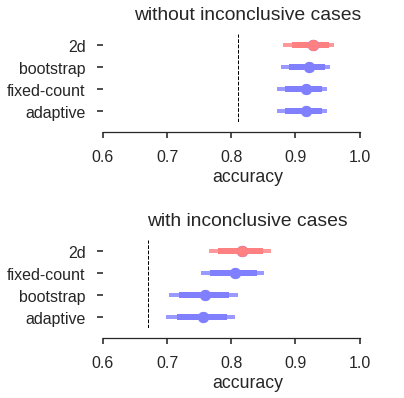

In [55]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(6,6))

ax1 = makePlot(bigConcAccDf,pGuessConc,ax1)
ax1.set_title('without inconclusive cases',y=1.1)
ax1.set_xlim(0.6,1.05)
ax1.set_ylim(-0.5,3.5)

ax2 = makePlot(bigAllAccDf,pGuess,ax2)
ax2.set_title('with inconclusive cases',y=1.1)
ax2.set_xlim(0.6,1.05)
ax2.set_ylim(-0.5,3.5)

sns.despine(left=True,offset=10,trim=True)
plt.tight_layout()
fig.savefig('../reports/figures/15-comparison-with-li-tool.png',dpi=300,bbox_inches='tight')
plt.show()

## make Wada Predictions

### get wada

In [63]:
wadaDataDf = pd.read_csv('../data/processed/csv/wada_clean.csv',index_col=[0],header=0)
wadaDataDf = wadaDataDf.loc[:,['wada']]
wadaDataDf.loc[:,'name'] = wadaDataDf.index

In [ ]:
wadaDataDf.tail()

In [65]:
wadaDataDf.shape

(62, 2)

#### make sure no wada patients were in the train set  

Here, we do not want to get any output

In [66]:
for n in [x[1] for x in my_nest]:
    for j in wadaDataDf.index:
        if j in n:
            print n,j

#### make sure all wada patients are in the test set

Here, we do not want to get any output

In [67]:
for j in wadaDataDf.index:
    in_test = False
    for n in [x[1] for x in my_test]:
        if j in n:
            in_test = True
    if not in_test:
        print j

### get all the information into one table

In [68]:
predsDf['name'] = [x.split('_')[0] for x in predsDf.index.get_level_values(1)]
predsDf['ixName'] = [x for x in predsDf.index.get_level_values(1)]
predsDf['clin'] = [x for x in predsDf.index.get_level_values(0)]
predsDf.index = pd.MultiIndex.from_arrays([predsDf.clin,predsDf.ixName])

In [69]:
wadaPredsDf = pd.merge(predsDf,wadaDataDf,left_on='name',right_on='name')
wadaPredsDf.index = pd.MultiIndex.from_arrays([wadaPredsDf['wada'],wadaPredsDf['name']])
wadaPredsDf.sort_index(inplace=True)

In [ ]:
wadaPredsDf.tail()

### distribution of values

In [71]:
wadaPredsDf.groupby('clin').count()['ixName']

clin
bilateral       13
inconclusive    21
left            35
right           11
Name: ixName, dtype: int64

In [72]:
wadaPredsDf.groupby('clin').count()['ixName'].sum()

80

In [73]:
wadaPredsDf.shape

(80, 8)

In [74]:
wadaUniquePats = np.unique(wadaPredsDf.index.get_level_values(1)).shape[-1]
wadaUniquePats

62

For validation, {{ wadaPredsDf.shape[0] }} fMRI data sets of {{ wadaUniquePats }} patients who also underwent Wada testing were used. 

#### counts of the 3 groups

In [75]:
wadaCountDf = pd.DataFrame( wadaPredsDf.groupby(level=1).first().groupby('wada').count()['ixName'] )
wadaCountDf

,ixName
wada,
bilateral,10
left,39
right,13


#### percentages of the 3 groups

In [76]:
(wadaCountDf/wadaCountDf.sum()*100).round(0)

,ixName
wada,
bilateral,16.0
left,63.0
right,21.0


### get all inconclusive cases

In [77]:
wadaIncPreds = wadaPredsDf[wadaPredsDf['clin']=='inconclusive'].copy()
wadaIncPreds.drop(['name','ixName','clin','wada'],axis=1,inplace=True)
wadaIncPreds.dropna(inplace=True)
wadaIncPreds.shape

(21, 4)

In [ ]:
wadaIncPreds.tail()

#### stats for inconclusive

In [79]:
bigIncAccDf = makeBigAccDf(wadaIncPreds,myLabeler,myDrop=True)
bigIncAccDf

,acc,nInc,n
2d,1.000000,20.0,1.0
fixed-count,0.571429,7.0,14.0
bootstrap,0.476190,NaN,21.0
adaptive,0.428571,NaN,21.0


guessing rate

In [80]:
wadaIncDf = wadaPredsDf[wadaPredsDf['clin']=='inconclusive']
pWadaIncGuess = (wadaIncDf['wada']=='left').sum()/float(wadaIncDf.shape[0])
pWadaIncGuess

0.66666666666666663

### same thing for conclusive cases

In [81]:
wadaConcPreds = wadaPredsDf[wadaPredsDf['clin']!='inconclusive'].copy()
wadaConcPreds.drop(['name','ixName','clin','wada'],axis=1,inplace=True)
wadaConcPreds.dropna(inplace=True)
print wadaConcPreds.shape
bigConcAccDf = makeBigAccDf(wadaConcPreds,myLabeler,myDrop=True)
bigConcAccDf

(59, 4)


,acc,nInc,n
2d,0.822222,14.0,45.0
bootstrap,0.810345,1.0,58.0
adaptive,0.810345,1.0,58.0
fixed-count,0.796610,NaN,59.0


In [82]:
wadaConcDf = wadaPredsDf[wadaPredsDf['clin']!='inconclusive']
pWadaConcGuess = (wadaConcDf['wada']=='left').sum()/float(wadaConcDf.shape[0])
pWadaConcGuess

0.61016949152542377

### plot

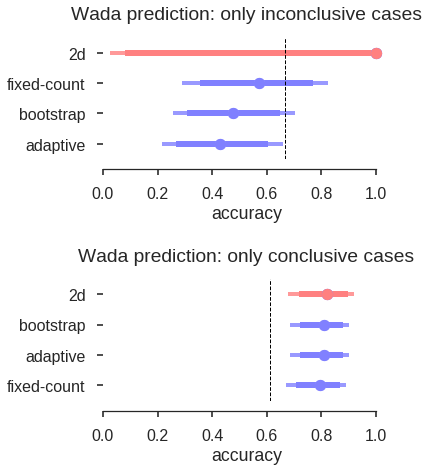

In [83]:
minX,maxX = .0,1.05

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(6,7))
ax1 = makePlot(bigIncAccDf-(10**-10),pWadaIncGuess,ax1)
ax1.set_title('Wada prediction: only inconclusive cases',y=1.1)
ax1.set_ylim(-0.5,3.5)
ax1.set_xlim(minX,maxX)

ax2 = makePlot(bigConcAccDf-(10**-10),pWadaConcGuess,ax2)
ax2.set_xlim(minX,maxX)
ax2.set_ylim(-0.5,3.5)
ax2.set_title('Wada prediction: only conclusive cases',y=1.1)

sns.despine(left=True,offset=10,trim=True)
plt.tight_layout()

plt.show()

### Whole sample

In [84]:
pWadaGuess = (wadaPredsDf['wada']=='left').sum()/float(wadaPredsDf.shape[0])
pWadaGuess

0.625

#### combine both approaches in the unflitered sample (conc+inconc)

In [85]:
wadaAllPreds = wadaPredsDf.copy()
wadaAllPreds.drop(['name','ixName','clin','wada'],axis=1,inplace=True)
wadaAllPreds.shape
bigAllAccDf = makeBigAccDf(wadaAllPreds,myLabeler,myDrop=True)
bigAllAccDf

,acc,nInc,n
2d,0.826087,34.0,46.0
fixed-count,0.753425,7.0,73.0
bootstrap,0.721519,1.0,79.0
adaptive,0.708861,1.0,79.0


In [86]:
wadaSelectPreds = wadaPredsDf.copy()
wadaSelectPreds = wadaSelectPreds[wadaSelectPreds['2d']!='inconclusive']
wadaSelectPreds.drop(['name','ixName','clin','wada'],axis=1,inplace=True)
wadaSelectPreds.shape
bigSelectAccDf = makeBigAccDf(wadaSelectPreds,myLabeler,myDrop=True)

bigSelectAccDf.index = ['2d+%s'%x for x in bigSelectAccDf.index ]
bigSelectAccDf.drop('2d+2d',axis=0,inplace=True)

bigSelectAccDf

,acc,nInc,n
2d+fixed-count,0.847826,NaN,46.0
2d+bootstrap,0.847826,NaN,46.0
2d+adaptive,0.847826,NaN,46.0


In [87]:
bigBigAccDf = pd.concat([bigAllAccDf,bigSelectAccDf]).sort_values(by='acc')

In [88]:
bigBigAccDf

,acc,nInc,n
adaptive,0.708861,1.0,79.0
bootstrap,0.721519,1.0,79.0
fixed-count,0.753425,7.0,73.0
2d,0.826087,34.0,46.0
2d+fixed-count,0.847826,NaN,46.0
2d+bootstrap,0.847826,NaN,46.0
2d+adaptive,0.847826,NaN,46.0


### plot

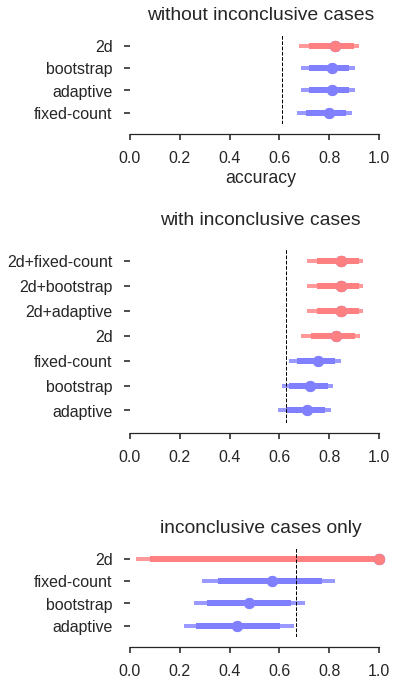

In [93]:
minX,maxX = .0,1.05

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 10))

ax1 = plt.subplot2grid((17, 1), (0, 0), rowspan=5)
ax1 = makePlot(bigConcAccDf-(10**-10),pWadaConcGuess,ax1)
ax1.set_xlim(minX,maxX)
ax1.set_ylim(-0.5,3.5)
ax1.set_title('without inconclusive cases',y=1.1)

ax2 = plt.subplot2grid((17, 1), (5, 0), rowspan=7)
ax2 = makePlot(bigBigAccDf-(10**-10),pWadaGuess,ax2)
ax2.set_xlim(minX,maxX)
ax2.set_ylim(-0.5,6.5)
ax2.set_xlabel('')
ax2.set_title('with inconclusive cases',y=1.1)

ax3 = plt.subplot2grid((17, 1), (12, 0), rowspan=5)
ax3 = makePlot(bigIncAccDf-(10**-10),pWadaIncGuess,ax3)
ax3.set_title('inconclusive cases only',y=1.1)
ax3.set_ylim(-0.5,3.5)
ax3.set_xlabel('')
ax3.set_xlim(minX,maxX)

sns.despine(left=True,offset=10,trim=True)
plt.tight_layout()

#plt.suptitle('Wada prediction',y=1.05,x=0.64)

fig.savefig('../reports/figures/15-wada.png',dpi=300,bbox_inches='tight')
plt.show()

## show mistakes  

Plot the instances where left and right were confused

In [94]:
myBigMistakes = pd.DataFrame()
sideList = np.array(['left','right'])
for side in sideList:
    otherSide = sideList[sideList!=side][-1]
    print side,otherSide
    thisBigMistakes = wadaPredsDf.loc[side][wadaPredsDf.loc[side]['2d']==otherSide]
    thisBigMistakes.index = [[side]*thisBigMistakes.shape[0],thisBigMistakes.index]
    myBigMistakes = pd.concat([myBigMistakes,thisBigMistakes])

left right
right left


In [ ]:
myBigMistakes

In [96]:
from nilearn import plotting

In [ ]:
for i in range(myBigMistakes.shape[0]):
    print '\n***************************'
    thisDf = myBigMistakes.iloc[i,:]
    thisFile = '../data/raw/nii/tMap_%s.nii'%thisDf['ixName']
    plotting.plot_stat_map(thisFile,threshold=3,title=thisDf['name'],cut_coords=(-50,15,15))
    plt.show()
    print myBigMistakes